## Cluster Finder

A quick, visual way to spot clusters in Gaia DR2 data, using distance, proper motion, and error cuts!

Instructions: Get Gaia DR2 Vizier data by querying Gaia DR3 (I/355/gaiadr3). To do this, type in a name for your object (for saving the file), its RA, Dec coordinates (ra,dec) in degrees, and a search radius (rad) in degrees. If you know the approximate distance range to your target range, you are encouraged to enter a rough, somewhat generous parallax minimum (pmin) and maximimum (pmax), as this will greatly cut down on the perhaps irrelevant targets and make the data file way more manageable. Sometimes astroquery's Vizier package doesn't run if it collects too many stars. You save the file in the format gaiasearch_objname.dat.

Use plotcut() to try different cuts in color-coded distance and proper motions, which you can toggle with 'dist' for distance, 'pra' for proper motion in right ascension, and 'pdec' for proper motion in declination. You can make cuts in error too, but I usually leave those as-is here. Keep cutting in plotcut() until you see a bunch of stars of roughly one color in distance, proper motion in RA, and proper motion in Dec. You can recenter your Vizier search if you so desire and rewrite your gaiasearch file.

Refine the cuts, centering whatever color you see in your one-color blob. The blob may get more colorful again as you make closer cuts, but the random distribution of field stars should diminish. When you're happy with your surviving blob of stars, produce a data file of these stars' Gaia DR3 data and create a final plot using the finalcut() function. Plot a Gaia DR3 BP-RP color-magnitude diagram of the stars using colmagBR(). Happy hunting!

If you use this code and find it helpful, please cite Yep & White 2022, in prep.

## Setup

In [44]:
#import Python stuff
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from os.path import exists

#Your directories:
# defaults are blank if you don't mind putting everything into the same folder with
# this .ipynb file.
ddir='data2/' #where to access and save your data
pdir='' #where to save your plots

from astroquery.vizier import Vizier
from astropy.coordinates import Angle
import astropy.coordinates as coord
import astropy.units as u

def VizierDR3(obj,RA,DEC,rad,pmin=0,pmax=1000,override='n'): #all in degrees
    keys=['_RAJ2000','_DEJ2000','RA_ICRS','e_RA_ICRS','DE_ICRS','e_DE_ICRS','Source','Plx','e_Plx','pmRA','e_pmRA','pmDE','e_pmDE','RUWE','Gmag','e_Gmag','BPmag','e_BPmag','RPmag','e_RPmag','RV','e_RV','Vbroad','e_Vbroad','Teff','b_Teff','B_Teff','logg','b_logg','B_logg','[Fe/H]','b_[Fe/H]','B_[Fe/H]','Dist','b_Dist','B_Dist','AG','b_AG','B_AG','E(BP-RP)','b_E(BP-RP)','B_E(BP-RP)','2MASS','d2MASS','n2MASS','m2MASS']

    #special
    keys2=['RAJ2000','DEJ2000','RA_ICRS','e_RA_ICRS','DE_ICRS','e_DE_ICRS','Source','Plx','e_Plx','pmRA','e_pmRA','pmDE','e_pmDE','RUWE','Gmag','e_Gmag','BPmag','e_BPmag','RPmag','e_RPmag','RV','e_RV','Vbroad','e_Vbroad','Teff','b_Teff','B_Teff','logg','b_logg','B_logg','__Fe_H_', 'b__Fe_H_', 'B__Fe_H_','Dist','b_Dist','B_Dist','AG','b_AG','B_AG','E_BP-RP_', 'b_E_BP-RP_', 'B_E_BP-RP_','_2MASS','d2MASS','n2MASS','m2MASS']
    V = Vizier(columns=['all'],column_filters={"Plx":">"+str(pmin)+" and <"+str(pmax)},row_limit=-1)
    result = V.query_region(coord.SkyCoord(ra=RA, dec=DEC,unit=(u.deg, u.deg)), radius=Angle(rad, "deg"), catalog='I/355/gaiadr3')
    print(result)

    #transform Vizier .csv into file!
    cols=[]
    label=['#ind']+keys
    for k in keys2:
        col=[str(r[k]) if str(r[k])!='--' else 'nan' for r in result[0]]
        cols.append(col)
    colls=[[str(i) for i in range(len(cols[0]))]]+cols
    del result

    if exists(ddir+'gaiasearch_'+obj+'.dat'):
        if override!='y':
            rewri=input("You've already saved Vizier Gaia DR3 data for "+obj+". Rewrite? 'y'/'n'\n")
            if rewri=='y':
                writedat(ddir,'gaiasearch_'+obj,colls,label)
            else:
                print('File NOT rewritten.')
        else:
            writedat(ddir,'gaiasearch_'+obj,colls,label)
    else:
        writedat(ddir,'gaiasearch_'+obj,colls,label)

#Ultimate opendat:
def opendatt(dir,filename,spl=''): #dir,'filename'. For opening a data file. Can then send through roundtable.
    f=open(dir+filename,'r')
    dat=f.readlines()
    f.close()
    if spl=='':
        labels=dat[0][0:-1].split()
        dat2=[[a.strip('\n') for a in d.split()] for d in dat if d[0]!='#']
    else:
        labels=dat[0][0:-1].split(spl)
        dat2=[[a.strip('\n') for a in d.split(spl)] for d in dat if d[0]!='#']
    dat3=[['nan' if a.strip()=='' else a for a in d] for d in dat2]
    return [dat3,labels]

def opendat(dirr,filename,params,splitchar=''): #Use as var,var,var...=opendat(dir,'filename',['keys']).
    if splitchar=='':
        dat,label=opendatt(dirr,filename)
    else:
        dat,label=opendatt(dirr,filename,splitchar)  #Get keys by first leaving ['keys'] blank: opendat(dirr,filename,[])
    print(label)
    varrs=[]
    for i in range(len(params)):
        j=label.index(params[i])
        try:
            var=np.array([float(d[j]) for d in dat]) #works for float.
            varrs.append(var)
        except ValueError:
            var=[d[j].strip() for d in dat] #works for strings.
            varrs.append(var)
    return varrs

def writedat(dirr,filename,pars,label): #.dat auto included. pars as [name,ra,dec] etc.
    datp=[[str(a[i]) for a in pars] for i in range(len(pars[0]))]
    f=open(dirr+filename+'.dat','w')
    print('\t'.join(label),file=f)
    print(label)
    for d in datp:
        print('\t'.join(d),file=f)
    f.close()
    print('It is written: '+filename+'.dat')

#Exploratory Cuts
#Doesn't save anything, just lets you look around. Do so until you're happy and then shove parameters into Final Cut. :)
#Object name, distance min + max, proper motion RA min + max, propermotion Dec min + max, parallax error max, proper motion error max, parameter to colorcode
def plotcut(objname,dmin,dmax,pramin,pramax,pdecmin,pdecmax,perrmax,pmerrmax,Color): #colorcode by Color param: 'dist', 'pra', 'pdec'    
    print("input: Object name, distance min + max, proper motion RA min + max, propermotion Dec min + max, parallax error max, proper motion error max, parameter to colorcode\n")
    ra,dec,p,perr,pra,praerr,pdec,pdecerr,G,Gerr,B,Berr,R,Rerr,rv,rverr=opendat(ddir,'gaiasearch_'+objname+'.dat',('_RAJ2000', '_DEJ2000','Plx', 'e_Plx','pmRA', 'e_pmRA', 'pmDE', 'e_pmDE','Gmag', 'e_Gmag','BPmag', 'e_BPmag', 'RPmag', 'e_RPmag', 'RV', 'e_RV'),splitchar='\t')
    #Vizier params:
    print('\nVizier search params (deg):\nRA:',(np.max(ra)+np.min(ra))/2.,'\nDec:',(np.max(dec)+np.min(dec))/2.,'\nRadius:',(np.max(dec)-np.min(dec))/2.)
    print('original length:',len(p))
    
    pmin,pmax=1000./dmax,1000./dmin
    pars=[ra,dec,p,perr,pra,praerr,pdec,pdecerr,G,Gerr]
    PARS=[]
    for par in pars:
        PAR=[par[i] for i in range(len(p)) if p[i]<pmax and p[i]>pmin and pra[i]<pramax and pra[i]>pramin and pdec[i]<pdecmax and pdec[i]>pdecmin and perr[i]<perrmax and praerr[i]<pmerrmax and pdecerr[i]<pmerrmax]
        PARS.append(PAR)
    #return PARS
    ra,dec,p,perr,pra,praerr,pdec,pdecerr,G,Gerr=PARS
    print('Cut length:',len(p))
    
    if Color=='dist':
        D,clab=1000./np.array(p),'$d$ (pc)' #distance
    if Color=='pra':
        D,clab=pra,'$\mu_{\\alpha}$ (mas/yr)' #pra
    if Color=='pdec':
        D,clab=pdec,'$\mu_{\delta}$ (mas/yr)' #pdec
    
    cmin=np.nanmin(D)
    cmax=np.nanmax(D) #capping it here for colorcoding
    precvrs=[(c-cmin)/(cmax-cmin) for c in D]
    CC=[plt.cm.rainbow(v) for v in precvrs]

    plt.figure(figsize=(12,10))
    plt.title(objname.upper()+' Region')
    plt.scatter(ra,dec,color=CC,s=25)  #s=50 for pres, 25 otherwise, or blank is fine.
    plt.xlim(np.max(ra)+0.1,np.min(ra)-0.1)
    plt.ylim(np.min(dec)-0.1,np.max(dec)+0.1)
    plt.ylabel('Dec ($^{\circ}$)')
    plt.xlabel('RA ($^{\circ}$)')    #plt.xlim(121,125)
    #plt.ylim(-35,-37)
    colors = plt.cm.rainbow(D)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.rainbow, norm=plt.Normalize(vmin=cmin, vmax=cmax))
    # fake up the array of the scalar mappable. Urgh…
    sm._A = []
    cbar=plt.colorbar(sm,pad=0.01)
    cbar.set_label(label=clab)
    return (objname,dmin,dmax,pramin,pramax,pdecmin,pdecmax,perrmax,pmerrmax)

#Final Cut
#Exports data file. You can add to plot as necessary. When you like it, you can save it.
#plt.legend(fontsize=10,scatterpoints=1,loc=4)
#plt.savefig(pdir+'gaiacands_'+objname+'_l'+str(magmax)+'.png')
#pars output from plotcut,RA Dec window,brighter-than-mag to mark]

def finalcut(pars,ramin,ramax,decmin,decmax,extras=[]): #box cut, from refining plotcut above.
    print("input: pars output from plotcut,RA Dec window,brighter-than-mag to mark\n")
    objname,dmin,dmax,pramin,pramax,pdecmin,pdecmax,perrmax,pmerrmax=pars
    
    ra,dec,p,perr,pra,praerr,pdec,pdecerr,G,Gerr,B,Berr,R,Rerr,rv,rverr,source,ruwe,Vbroad,e_Vbroad,Teff,b_Teff,B_Teff,logg,b_logg,B_logg,FeH,b_FeH,B_FeH,Dist,b_Dist,B_Dist,AG,b_AG,B_AG,EBPRP,b_EBPRP,B_EBPRP,m2MASS,d2MASS,n2MASS,m2MASS=opendat(ddir,'gaiasearch_'+objname+'.dat',('_RAJ2000', '_DEJ2000','Plx', 'e_Plx','pmRA', 'e_pmRA', 'pmDE', 'e_pmDE','Gmag', 'e_Gmag','BPmag', 'e_BPmag', 'RPmag', 'e_RPmag', 'RV', 'e_RV','Source','RUWE','Vbroad','e_Vbroad','Teff','b_Teff','B_Teff','logg','b_logg','B_logg','[Fe/H]','b_[Fe/H]','B_[Fe/H]','Dist','b_Dist','B_Dist','AG','b_AG','B_AG','E(BP-RP)','b_E(BP-RP)','B_E(BP-RP)','2MASS','d2MASS','n2MASS','m2MASS'),splitchar='\t')
    print('original length:',len(p))
    
    pmin,pmax=1000./dmax,1000./dmin
    pars=[ra,dec,p,perr,pra,praerr,pdec,pdecerr,G,Gerr,B,Berr,R,Rerr,rv,rverr,source,ruwe,Vbroad,e_Vbroad,Teff,b_Teff,B_Teff,logg,b_logg,B_logg,FeH,b_FeH,B_FeH,Dist,b_Dist,B_Dist,AG,b_AG,B_AG,EBPRP,b_EBPRP,B_EBPRP,m2MASS,d2MASS,n2MASS,m2MASS]
    PARS=[]
    for par in pars:
        PAR=[par[i] for i in range(len(p)) if( p[i]<pmax and p[i]>pmin and pra[i]<pramax and pra[i]>pramin and pdec[i]<pdecmax and pdec[i]>pdecmin and perr[i]<perrmax and praerr[i]<pmerrmax and pdecerr[i]<pmerrmax and ra[i]<ramax and ra[i]>ramin and dec[i]<decmax and dec[i]>decmin) or i in extras]
        PARS.append(PAR)
    #return PARS
    ra,dec,p,perr,pra,praerr,pdec,pdecerr,G,Gerr,B,Berr,R,Rerr,rv,rverr,source,ruwe,Vbroad,e_Vbroad,Teff,b_Teff,B_Teff,logg,b_logg,B_logg,FeH,b_FeH,B_FeH,Dist,b_Dist,B_Dist,AG,b_AG,B_AG,EBPRP,b_EBPRP,B_EBPRP,m2MASS,d2MASS,n2MASS,m2MASS=PARS
    count=len(p)
    print('Cut length:',count)
    
    lab=('#ra', 'dec','p', 'perr','pra', 'praerr', 'pdec', 'pdecerr','G', 'Gerr','BP','BPerr','RP','RPerr','rv','rverr','source','ruwe','Vbroad','e_Vbroad','Teff','b_Teff','B_Teff','logg','b_logg','B_logg','[Fe/H]','b_[Fe/H]','B_[Fe/H]','Dist','b_Dist','B_Dist','AG','b_AG','B_AG','E(BP-RP)','b_E(BP-RP)','B_E(BP-RP)','2MASS','d2MASS','n2MASS','m2MASS')
    ds=[ra,dec,p,perr,pra,praerr,pdec,pdecerr,G,Gerr,B,Berr,R,Rerr,rv,rverr,source,ruwe,Vbroad,e_Vbroad,Teff,b_Teff,B_Teff,logg,b_logg,B_logg,FeH,b_FeH,B_FeH,Dist,b_Dist,B_Dist,AG,b_AG,B_AG,EBPRP,b_EBPRP,B_EBPRP,m2MASS,d2MASS,n2MASS,m2MASS]
    dsp=[[str(d[i]) for d in ds] for i in range(len(ra))]
    
    fname='gaiacands_'
    if len(extras)>0:
        print('extras: ('+str(len(extras))+')')
        print(extras)
        fname='gaiacands2_'
        print('Cut length + extras:',count+len(extras))
    f=open(ddir+fname+objname+'.dat','w')
    print('\t'.join(lab),file=f)
    for d in dsp:
        print('\t'.join(d),file=f)
    f.close()
    
    print('\nSaved data to '+ddir+fname+objname+'.dat.\n')
    
    print('G mag:',np.min(G),'-',np.max(G),', straight mean',np.mean(G))
    PARS=plotcut(objname,dmin,dmax,pramin,pramax,pdecmin,pdecmax,perrmax,pmerrmax,'dist')
    plt.ylim(decmin,decmax)
    plt.xlim(ramax,ramin)
    plt.legend(fontsize=10,scatterpoints=1)
    #plt.savefig(pdir+objname+'_gaiacands_l'+str(magmax)+'.png')
    
    return objname,ramin,ramax,decmin,decmax,dmin,dmax,pramin,pramax,pdecmin,pdecmax,perrmax,pmerrmax,count

#Color-Magnitude Diagaram
#Plot a rough Gaia BP-RP vs. BP color-magnitude diagram of your stars
def colmagBR(objname):
    print('input: Object name, average distance to potential cluster, save plot y or n')
    p,perr,G,Gerr,B,Berr,R,Rerr=opendat(ddir,'gaiacands_'+objname+'.dat',('p', 'perr','G', 'Gerr','BP','BPerr','RP','RPerr'),splitchar='\t') #maybe add add-nan capability for blank slots!
    
    plt.figure(figsize=(10,6))
    
    plt.scatter(np.array(B)-np.array(R),B,s=25) #s=50 for pres
    plt.xlabel('BP-RP')
    plt.ylabel('BP')
    plt.ylim(np.nanmax(B)+0.3,np.nanmin(B)-0.3)
    plt.legend(fontsize=12)
    
    #plt.savefig(ddir+'gaiacolormag_'+objname+'.png')

In [34]:
objname='NGC2547_DR3' #specify your object name. For example, cluster1.
VizierDR3(objname,122.4,-49.3,1.,pmin=2.1,pmax=3.3)

TableList with 1 tables:
	'0:I/355/gaiadr3' with 226 column(s) and 4004 row(s) 
You've already saved Vizier Gaia DR3 data for NGC2547_DR3. Rewrite? 'y'/'n'
y
['#ind', '_RAJ2000', '_DEJ2000', 'RA_ICRS', 'e_RA_ICRS', 'DE_ICRS', 'e_DE_ICRS', 'Source', 'Plx', 'e_Plx', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'RUWE', 'Gmag', 'e_Gmag', 'BPmag', 'e_BPmag', 'RPmag', 'e_RPmag', 'RV', 'e_RV', 'Vbroad', 'e_Vbroad', 'Teff', 'b_Teff', 'B_Teff', 'logg', 'b_logg', 'B_logg', '[Fe/H]', 'b_[Fe/H]', 'B_[Fe/H]', 'Dist', 'b_Dist', 'B_Dist', 'AG', 'b_AG', 'B_AG', 'E(BP-RP)', 'b_E(BP-RP)', 'B_E(BP-RP)', '2MASS', 'd2MASS', 'n2MASS', 'm2MASS']
It is written: gaiasearch_NGC2547_DR3.dat


input: Object name, distance min + max, proper motion RA min + max, propermotion Dec min + max, parallax error max, proper motion error max, parameter to colorcode

['#ind', '_RAJ2000', '_DEJ2000', 'RA_ICRS', 'e_RA_ICRS', 'DE_ICRS', 'e_DE_ICRS', 'Source', 'Plx', 'e_Plx', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'RUWE', 'Gmag', 'e_Gmag', 'BPmag', 'e_BPmag', 'RPmag', 'e_RPmag', 'RV', 'e_RV', 'Vbroad', 'e_Vbroad', 'Teff', 'b_Teff', 'B_Teff', 'logg', 'b_logg', 'B_logg', '[Fe/H]', 'b_[Fe/H]', 'B_[Fe/H]', 'Dist', 'b_Dist', 'B_Dist', 'AG', 'b_AG', 'B_AG', 'E(BP-RP)', 'b_E(BP-RP)', 'B_E(BP-RP)', '2MASS', 'd2MASS', 'n2MASS', 'm2MASS']

Vizier search params (deg):
RA: 122.39967346636001 
Dec: -49.30090020857 
Radius: 0.9938349860300022
original length: 4004
Cut length: 288


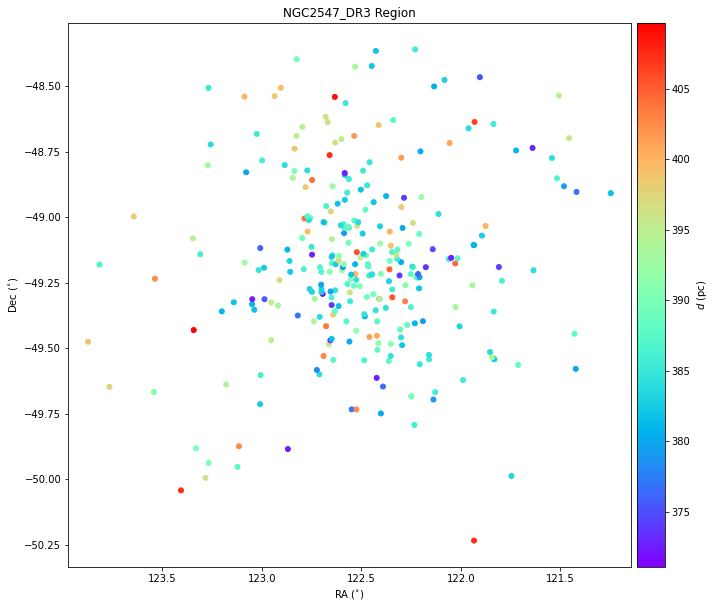

In [35]:
cluster1pars=plotcut(objname,370.,410.,-9.2,-7.5,3.,5.6,0.1,0.16,'dist') #using median errors for G mag 17 as detailed in Appendix C of Lindegren et al. 2018

input: pars output from plotcut,RA Dec window,brighter-than-mag to mark

['#ind', '_RAJ2000', '_DEJ2000', 'RA_ICRS', 'e_RA_ICRS', 'DE_ICRS', 'e_DE_ICRS', 'Source', 'Plx', 'e_Plx', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'RUWE', 'Gmag', 'e_Gmag', 'BPmag', 'e_BPmag', 'RPmag', 'e_RPmag', 'RV', 'e_RV', 'Vbroad', 'e_Vbroad', 'Teff', 'b_Teff', 'B_Teff', 'logg', 'b_logg', 'B_logg', '[Fe/H]', 'b_[Fe/H]', 'B_[Fe/H]', 'Dist', 'b_Dist', 'B_Dist', 'AG', 'b_AG', 'B_AG', 'E(BP-RP)', 'b_E(BP-RP)', 'B_E(BP-RP)', '2MASS', 'd2MASS', 'n2MASS', 'm2MASS']
original length: 4004


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Cut length: 215

Saved data to data2/gaiacands_NGC2547_DR3.dat.

G mag: 7.289064 - 18.168436 , straight mean 14.971282432558139
input: Object name, distance min + max, proper motion RA min + max, propermotion Dec min + max, parallax error max, proper motion error max, parameter to colorcode

['#ind', '_RAJ2000', '_DEJ2000', 'RA_ICRS', 'e_RA_ICRS', 'DE_ICRS', 'e_DE_ICRS', 'Source', 'Plx', 'e_Plx', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'RUWE', 'Gmag', 'e_Gmag', 'BPmag', 'e_BPmag', 'RPmag', 'e_RPmag', 'RV', 'e_RV', 'Vbroad', 'e_Vbroad', 'Teff', 'b_Teff', 'B_Teff', 'logg', 'b_logg', 'B_logg', '[Fe/H]', 'b_[Fe/H]', 'B_[Fe/H]', 'Dist', 'b_Dist', 'B_Dist', 'AG', 'b_AG', 'B_AG', 'E(BP-RP)', 'b_E(BP-RP)', 'B_E(BP-RP)', '2MASS', 'd2MASS', 'n2MASS', 'm2MASS']

Vizier search params (deg):
RA: 122.39967346636001 
Dec: -49.30090020857 
Radius: 0.9938349860300022
original length: 4004
Cut length: 288


('NGC2547_DR3',
 121.7,
 123.2,
 -49.7,
 -48.8,
 370.0,
 410.0,
 -9.2,
 -7.5,
 3.0,
 5.6,
 0.1,
 0.16,
 215)

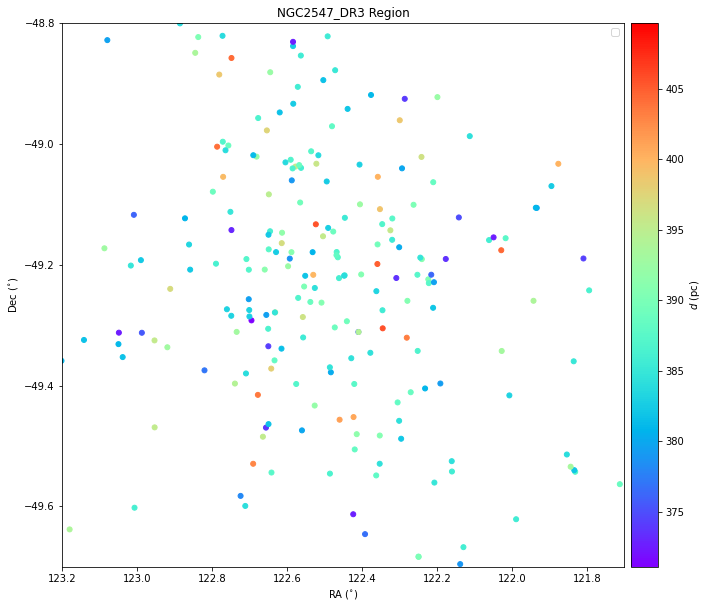

In [45]:
finalcut(cluster1pars,121.7,123.2,-49.7,-48.8)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


input: Object name, average distance to potential cluster, save plot y or n
['#ra', 'dec', 'p', 'perr', 'pra', 'praerr', 'pdec', 'pdecerr', 'G', 'Gerr', 'BP', 'BPerr', 'RP', 'RPerr', 'rv', 'rverr', 'source', 'ruwe', 'Vbroad', 'e_Vbroad', 'Teff', 'b_Teff', 'B_Teff', 'logg', 'b_logg', 'B_logg', '[Fe/H]', 'b_[Fe/H]', 'B_[Fe/H]', 'Dist', 'b_Dist', 'B_Dist', 'AG', 'b_AG', 'B_AG', 'E(BP-RP)', 'b_E(BP-RP)', 'B_E(BP-RP)', '2MASS', 'd2MASS', 'n2MASS', 'm2MASS']


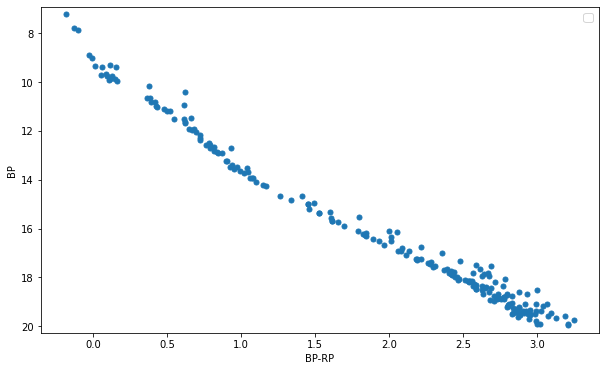

In [46]:
colmagBR('NGC2547_DR3')